## Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? 

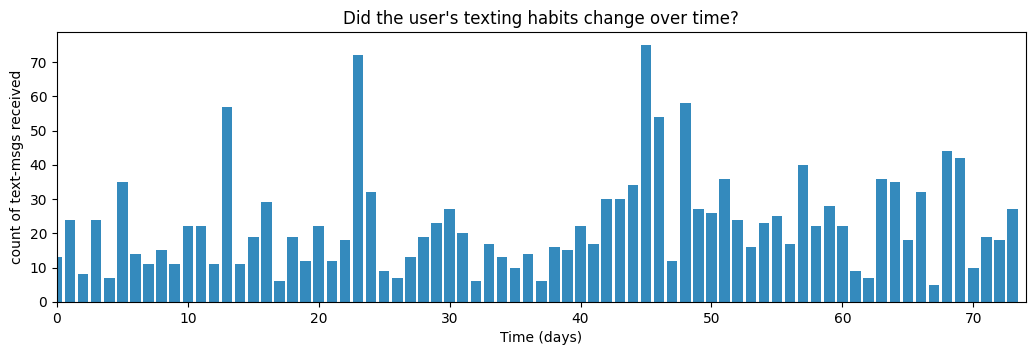

In [2]:
import scipy.stats as stats
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt


figsize(12.5, 3.5)
count_data = np.loadtxt("../../data/txtdata.csv")
for i in range(40,45):
    count_data[40:45] += (i-39)
count_data[45:] += 5
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

Poisson random variable would be a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *change-point*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Given all the information above combined with the Bayes rule we can rigorously derive overall prior distribution of the parameters as well as the likelihood, however given that this course concentrates more on deploying Bayesian models rather than on mathematical aspects of them we will omit this part in order to save time and turn immediately to PyMC, a Python library for performing Bayesian analysis.


The below code for MCMC inference is written in PyMC. Studying PyMC is not within the scope of this course and we use MCMC here exclusively for illustrating purposes and for results comparison. Therefore, we are not discussing the code here.

The code below sets up an MCMC sampling method with parameters ($\tau, \lambda_1, \lambda_2$ )


In [2]:
#!pip install pymc
import pymc as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=44)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

In [3]:
with model:
    #idx = np.arange(n_count_data) # Index
    idx=np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [4]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [ ]:
%%time
with model:
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000, step=step,
                      return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 13 seconds.


CPU times: user 8.21 s, sys: 1.9 s, total: 10.1 s
Wall time: 1min 10s


Finally we can extract the results of the MCMC and plot the parameter distributions

In [17]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']
lambda_1_samples

array([18.30967529, 18.30967529, 18.33689313, ..., 17.87035742,
       18.02463527, 19.29621387])

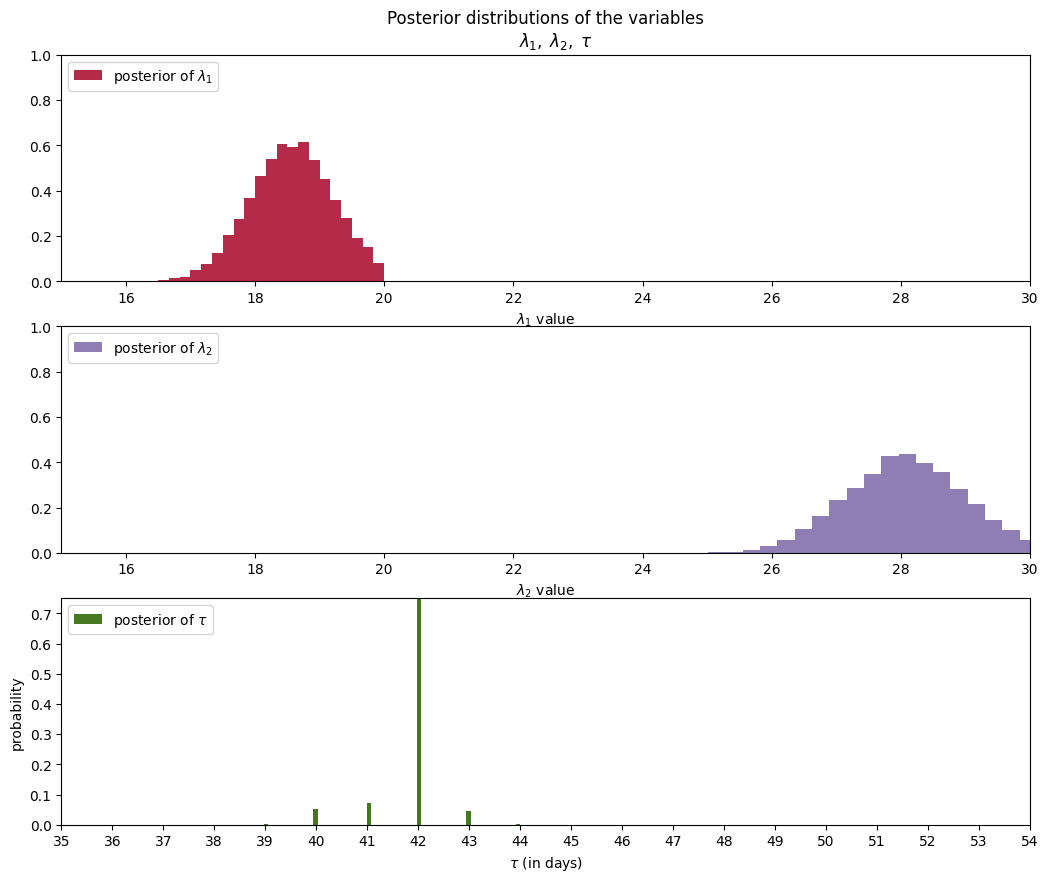

In [8]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
bins = np.linspace(15, 20, 31)

plt.hist(lambda_1_samples, histtype='stepfilled',
          bins=bins, alpha=0.85, 
          label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.show()

Let us now visualise the average number of text messages expected on a certain day. In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

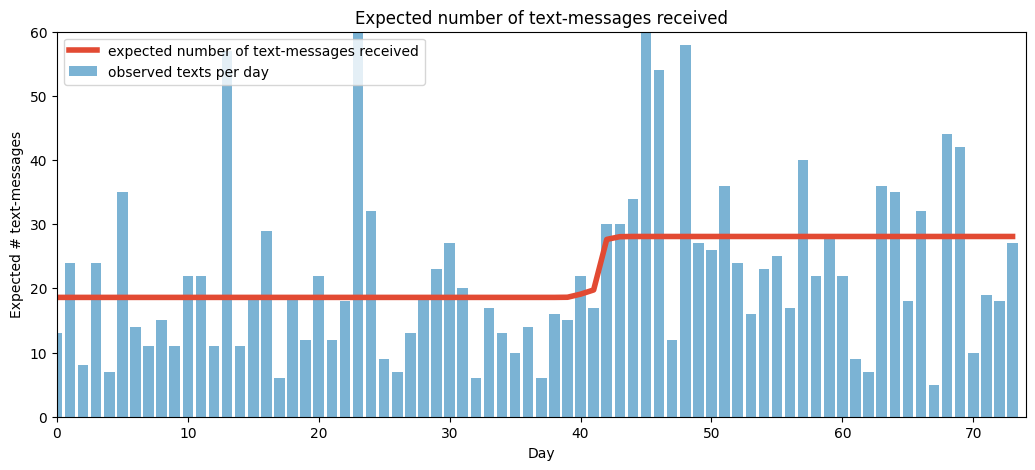

In [9]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()

### Putting the model into SBI framework

Firstly we would need to write down a simulator function dependent on the parameters from the above: $(\tau,\lambda_1,\lambda_2)$. We fix the parameter $\alpha=\frac1{20}$, and as for the priors, we keep them to be as before using function `MultipleIndependent` to combine different probability distributions.

Note, that all the distributions either need to belong to `sbi` package or `torch.distributions`, and the parameters of the distributions have to be defined as `torch.Tensors`


In [ ]:
import torch
from sbi.utils import MultipleIndependent
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import infer
import numpy as np
import scipy.stats as stats



def simulator(params):
        data = np.r_[stats.poisson.rvs(mu=params[0], size=int(params[2])), stats.poisson.rvs(mu=params[1], size=74 - int(params[2]))]
        return data
    

alpha=1./20.    
prior=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([30]),high=torch.Tensor([60]))
    ]
)
        

Let us infer the variable `posterior` which is going to correspond to posterior distribution in case we use SNPE method. One can replace SNPE by SNRE and observe that the training runs way faster. However, sampling from the posterior would take way more time since it actually requires calling the sampling algorithm.

In [ ]:
%%time
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 144 epochs.CPU times: user 5h 39min 39s, sys: 16.6 s, total: 5h 39min 55s
Wall time: 2min 49s


Use the above observation to sample from the posterior distribution. 

In [ ]:
observation=count_data

#observation=observation
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Plot the distributions of the parameters $\lambda_1$, $\lambda_2$, $\tau$

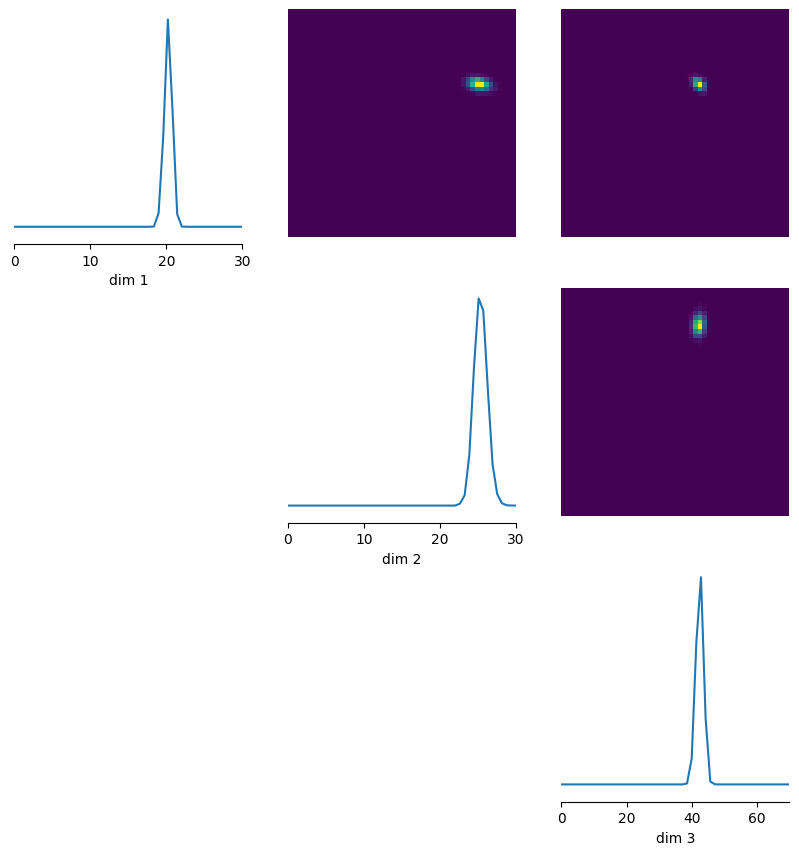

In [13]:
%matplotlib inline
from sbi.analysis.plot import pairplot

fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')


Clearly, the results of the above inference look very different from what we have obtained previsously with an MCMC method. As previously, we visualise the expected number of text messages a day and display it on a graph. We see that the above inference has certain grounds too, especially given the absence of ground truth in this case. However, this raises a question of whether the prior we chose for the SBI model was good enough and whether the number of simulation was sufficient.

Note that in all cases here we were using the amortized neural inference, meaning that we used exclusively simulations to build up an approximation for posterior/likelihood/likelihood ratio. This means that we can easily run inference on a different observation and get different values of the parameters without re-running the whole inference. On the other hand, we are obviously not restricted to feeding only one observation to our inference. Therefore, we can run inference on arbitrarily many available observations.

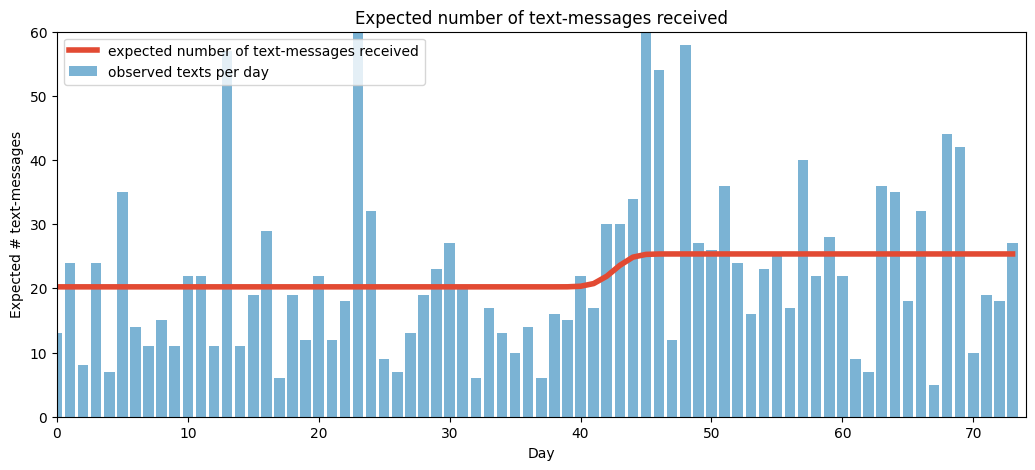

In [ ]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < samples[:,2]
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (samples[ix,0].sum()
                                   + samples[~ix,1].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()